# Healing Hugs Exploratory Analysis
Summary: This analysis looks at several variables to see if they are correlated to a husband receiving a healing hug from his wife. 

What is a healing hug, you ask? Just as one can consciously feel a physiological reponse to stress (think about when you are super stressed and your body physically feels different), this husband reports that with some hugs with his wife, he can feel the physiological reponse of muscle relaxation and lowered stressed. He presumes that during these hugs, his body releases healing hormones (or receives at least some form of healing).  

As he claims these are healthy, he would like to receive as many of these as possible. Who wouldn't?! 

For years, the husband wondered if his wife's work schedule and workout status affected whether or not he receives one. He had no hard evidence. However, once he discovered I was getting into data science, he began recording some variables with the hope one day I would be able to provide insight. After nearly 2.5 years, that day has come. 

At his request, I redacted the data to some extent prior to puclic exposure. The end of that redaction is where this project begins: healing_hugs.csv.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools import add_constant

# Data exploration
Let's read in the data and see what we have...

In [3]:
raw = pd.read_csv('healing_hugs.csv')
raw.head()

,Day_of_week,Workout,Work_shift,Healing_hug,Month,Year,Pto
0,Sun,1.0,on call,0.0,8,2021,0
1,Mon,0.0,late,1.0,8,2021,0
2,Tue,0.0,late,0.0,8,2021,0
3,Wed,0.0,late,0.0,9,2021,0
4,Thu,NaN,late,NaN,9,2021,0


"Workout" = Did the wife workout?
"Work_shift" = The wife's work shift starting a 6am, 7-8am, or 9am for 'early', 'mid', and 'late', respectively. 'on-call' is on Sunday's only.
"Healing_hug" = Did the husband receive a healing hug?
"Pto" = Was the wife on paid-time-off (PTO)?

Immediately, we see NaN's so we will need to preprocess the data. Further, we have categorical and numerical features; these will need to be handled differently. The husband indicates any "blank" value should be "none" or 0, so that prevents us from having to impute or ignore observations.

<Axes: >

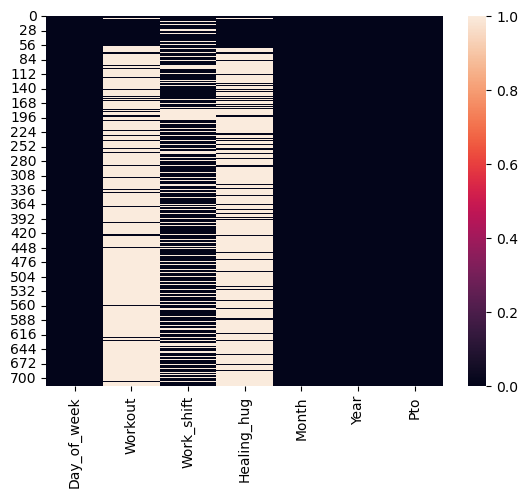

In [5]:
# To get a better idea of NaN's, lets quickly inspect a heatmap
sns.heatmap(raw.isnull())

In [13]:
# Create a new dataframe in case we need the original later
hh = raw.copy(deep=True)
# Because "Work_shift" is categorical, we will address it first, then fill the rest with 0
hh = hh.fillna({"Work_shift": "none"}).fillna(0)

In [20]:
# check unique values
for col in hh:
    print(col + str(hh[col].unique()))

Day_of_week['Sun' 'Mon' 'Tue' 'Wed' 'Thu' 'Fri' 'Sat']
Workout[1. 0.]
Work_shift['on call' 'late' 'early' 'none' 'mid']
Healing_hug[0. 1.]
Month[ 8  9 10 11 12  1  2  3  4  5  6  7]
Year[2021 2022 2023 2024]
Pto[0 1]


In [27]:
# Clean up a few items:
# Work_shift "off" is same as "none", so refine those values
hh.Work_shift.replace(to_replace="off", value="none", inplace=True)
# We don't need the extra spaces in 'early '
hh.Work_shift = hh.Work_shift.str.strip()

In [28]:
# Three values in our target column, "Healing_hug", will affect how we do logistic regression. Let's investigate further...
hh.Healing_hug.value_counts()

0.0    600
1.0    115
Name: Healing_hug, dtype: int64

In [26]:
# Okay, easy enough. Let's convert that lone 2 to a 1. It will not alter the anaylsis in any significant way. (We will use binary logistic regression). Furthermore, we have enough observations in each class to believe our mathematical analysis will have value.
hh.Healing_hug.replace(to_replace=2, value=1, inplace=True)

Day_of_week['Sun' 'Mon' 'Tue' 'Wed' 'Thu' 'Fri' 'Sat']
Workout[1. 0.]
Work_shift['on call' 'late' 'early' 'none' 'mid']
Healing_hug[0. 1.]
Month[ 8  9 10 11 12  1  2  3  4  5  6  7]
Year[2021 2022 2023 2024]
Pto[0 1]


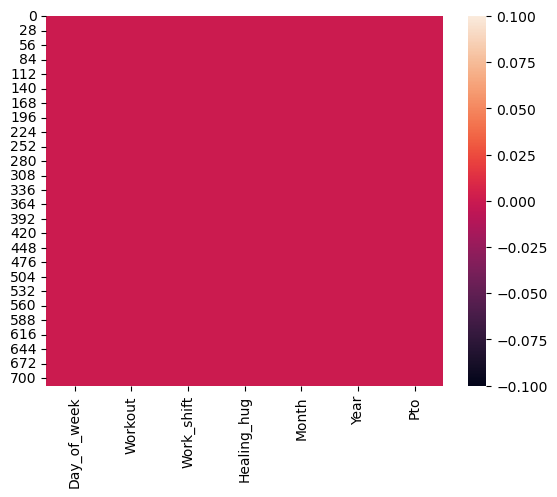

In [25]:
# Let's confirm the data is how we want
sns.heatmap(hh.isnull())
for col in hh:
    print(col + str(hh[col].unique()))


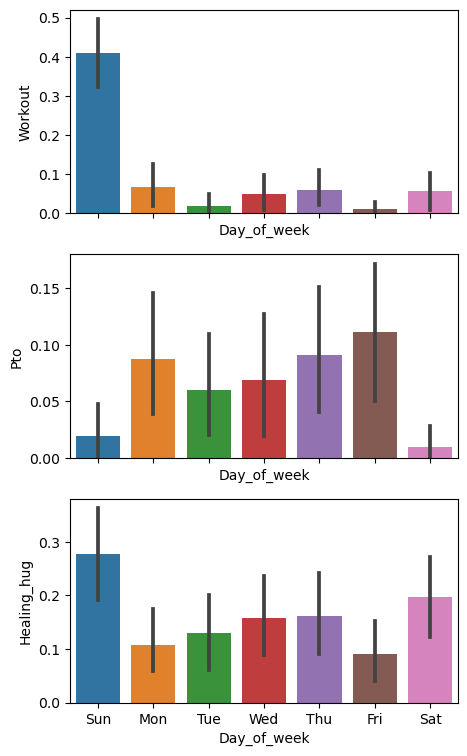

In [37]:
# Looks good, let's do some exploratory analysis with bar graphs to 1. visualize any trends and 2. ensure we have enough data for regression.
x = hh.Day_of_week
ys = ["Workout", "Pto", "Healing_hug"]

fig, axes = plt.subplots(nrows=len(ys), sharex=True)
fig.set_size_inches(5, 9)

for i in range(len(ys)):
    sns.barplot(x=x, 
                y=hh[ys[i]],
                ax=axes[i],)

### Workout vs Day_of_week
The day of week certainly seems to be highly correlated with whether or not the wife works out. After sharing these results with the husband, he revealed they take turns on the weekend working out because of their family situation; Sunday is typically her day to go. 

### Pto vs Day_of_week
Nothing too surprising here. Most people take PTO during the week. 

### Healing_hug
It appears the husband is more likely to receive a healing hug on the weekend compared to during the week, with the highest chance on Sunday. Because Sunday is highly correlated to the wife working out, teasing out to what degree working out affects the chances of a healing hug will be interesting. We may need to group the days of the week as "Sunday" and "Non-Sunday" to ensure we have enough data for a strong analysis.

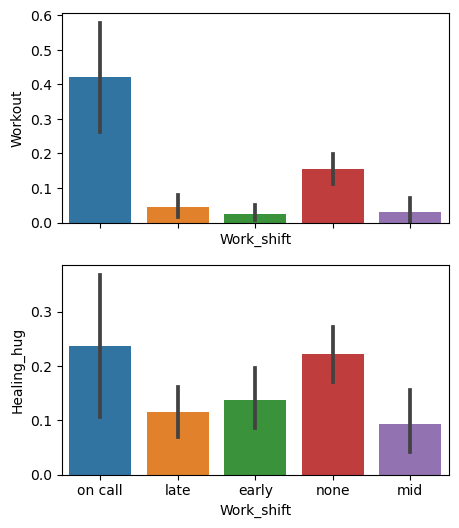

In [38]:
x = hh.Work_shift
ys = ["Workout", "Healing_hug"]

fig, axes = plt.subplots(nrows=len(ys), sharex=True)
fig.set_size_inches(5, 6)

for i in range(len(ys)):
    sns.barplot(x=x, 
                y=hh[ys[i]],
                ax=axes[i],)

### Workout vs Work_shift
Work shift seems to be correlated with workout status, which compounds those features. 

### Healing_hug vs Work_shift
The chances of a healing hug does seem to be correlated with work shift. However, recall that shifts 'early', 'mid', and 'late' correspond to only weekdays, while 'none' and 'on-call' are nearly always weekends. The means and errors of 'early', 'mid', and 'late' shifts all fall within each other. Thus, the differences within those three shifts are little to none. Understanding shifts 'none' and 'on-call' are on weekends, this graph suggests healing hugs are more common on the weekends than the weekdays. 

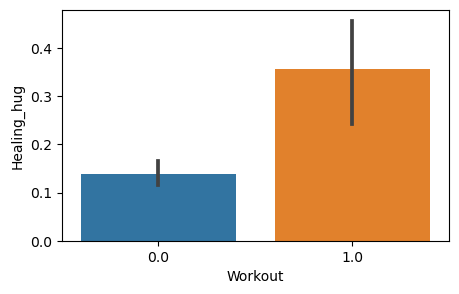

In [39]:
x = hh.Workout
ys = ["Healing_hug"]

fig, axes = plt.subplots(nrows=len(ys), sharex=True)
fig.set_size_inches(5, 3)

for i in range(len(ys)):
    sns.barplot(x=x, 
                y=hh[ys[i]])

### Healing_hug vs Workout
This graph suggests healing hugs and the wife working out are likely correlated. Important to remember, correlation does not imply causality. 

# Logistic Regression
Because receiving or not receiving a healing hug is a discrete target, we will use logistic regression using the remaining variables as features. 

Before applying a logistic regression model, we need to convert the categorical variables into dummy variables (aka one-hot encoding). Significantly, we will remove one column to avoid multicollinearity (ex: if Sun-Fri are all 0, then Sat must be 1). Also, we add a constant as we do not assume the curve necessarily goes through the origin.

In [40]:
days = pd.get_dummies(hh.Day_of_week)  # hold off on dropping a column until we see multicollinearities
ws = pd.get_dummies(hh.Work_shift)

In [44]:
hh_log = pd.concat([hh, days, ws], axis=1)
hh_log.drop(["Day_of_week", "Work_shift"], axis=1, inplace=True)

<Axes: >

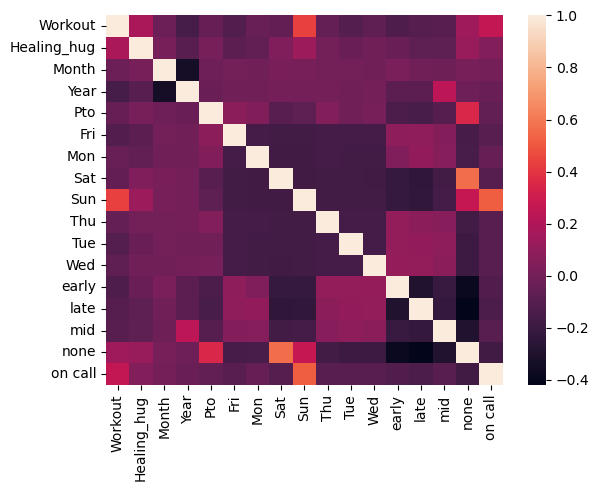

In [45]:
sns.heatmap(hh_log.corr())

In [46]:
# Because of the high correlations between "Sun", "none", and "Workout", we choose "Sun" as the 'days' column to remove. 
# Similarly, we remove the "none" column from 'ws'
hh_log.drop(["Sun", "none"], axis=1, inplace=True)

<Axes: >

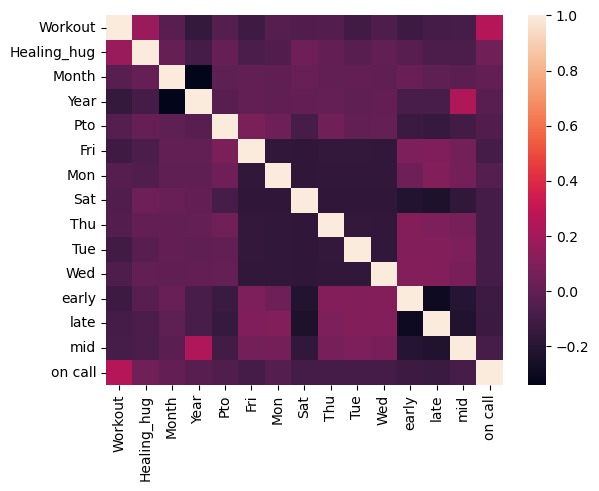

In [47]:
sns.heatmap(hh_log.corr())

In [48]:
# Interestingly, "mid" is moderately correlated to "Year". Perhaps the wife worked more or less of her mid-shift in a particular year(s). We will ignore that for now. It does look as though healing hugs are \
# most correlated to working out with no significant correlation to work shift. 
# Let's look at the variance inflation factor (vif) before moving on to logistic regression. This will put numbers to the graph above. 
def vif(df, target):
    X = add_constant(df.loc[:, df.columns != target])
    return pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index = X.columns)  

In [49]:
target = "Healing_hug"
vif(hh_log, target)

const      9.597573e+06
Workout    1.303679e+00
Month      1.151237e+00
Year       1.264833e+00
Pto        1.895963e+00
Fri        4.040642e+00
Mon        3.776184e+00
Sat        2.329812e+00
Thu        3.991869e+00
Tue        4.080095e+00
Wed        4.098180e+00
early      3.910134e+00
late       4.151093e+00
mid        3.101553e+00
on call    1.389997e+00
dtype: float64

Fortunately, none of the values are above 5, a commonly used threshold indicating higher-than-desired multicollinearity. However, the VIF does clearly show days of the week and workshifts have moderate collinearity, as expected. 

Let's go ahead and split our dataframe into features and target and into training and testing splits. 20% of the dataframe will be held out for testing. 

In [107]:
X = hh_log.drop(["Healing_hug"], axis=1)
y = hh_log['Healing_hug']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=235)

Because we have an unbalanced number of observations between receiving and not receiving a healing hug, we will use the argument "class_weight=balanced" to help the model.

In [92]:
log_model = LogisticRegression(class_weight="balanced")
log_model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

Now let's check how well the model predictions on the held out 20%.

In [108]:
y_preds = log_model.predict(X_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

         0.0       0.86      0.62      0.72       117
         1.0       0.24      0.54      0.33        26

    accuracy                           0.60       143
   macro avg       0.55      0.58      0.52       143
weighted avg       0.74      0.60      0.65       143



As we can see, accuracy is 60% with the precision being substantially higher for no healing hug than for one. The majority of predictions are no healing hug which the maximun liklihood estimation method would predict as well. 

While the husband was hoping the data would provide a higher accuracy of predicting when he receives a healing hug, he was comforted knowing the relationship with his wife cannot be reduced to a few simple variables. After all, relationships are complex. 

Let's take a look at the importance of each feature below. Positive values indicate a feature is positively correlated with the target (ie. healing hug) whereas negative values indicate a feature is negatively correlated the chance.

<BarContainer object of 14 artists>

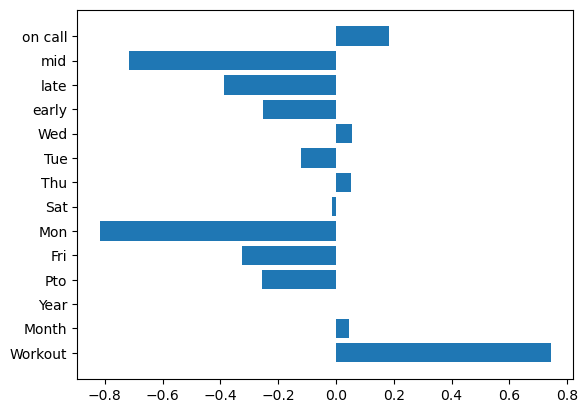

In [96]:
feat_importance = log_model.coef_.flatten()
plt.barh(X.columns, feat_importance)

Clearly, the wife working out was/is the biggest feature with a positive correlation to the husband receiving a healing hug. However,, correlation does not imply causation. 

My recommendation to the husband was to continue to provide an environment that gives his wife the freedom to work out (ie. remove barriers to working out where possible). Furthermore, consider ways he can increase his support of his wife during the week (while she is working) for two reason. First, it may increase the chance of him getting a healing hug. Second, and more importantly, relationships are a two-way street. There are deeply rich benefits of giving in a relationshiop which go well beyond the scope of this project.

For grins, let's see what happens when we reduce the days of the week to weekday/weekend and remove the work shifts as these two categories have moderate multicollinearity. Furthermore, the above analysis reveals the differences between shifts are small to none. 

In [64]:
hh2 = hh.copy(deep=True)
hh2.drop(["Work_shift"], axis=1, inplace=True)
hh2.Day_of_week.replace({'Sun' : 'weekend',
                         'Mon': 'weekday',
                         'Tue': 'weekday',
                         'Wed': 'weekday',
                         'Thu': 'weekday',
                         'Fri': 'weekday',
                         'Sat': 'weekend'}, inplace=True)



In [73]:
day_types = pd.get_dummies(hh2.Day_of_week, drop_first=False)
hh2_log = pd.concat([hh2, day_types], axis=1)
hh2_log.drop(["Day_of_week"], axis=1, inplace=True)
hh2_log.drop(["weekday"], axis=1, inplace=True)  # remove one column to avoid multicollinearity

<Axes: >

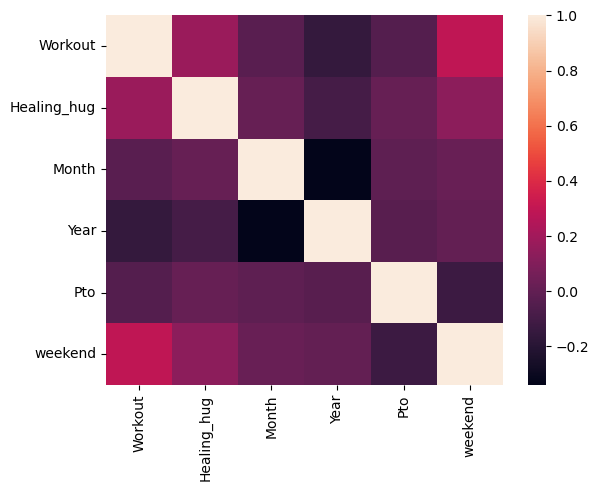

In [74]:
sns.heatmap(hh2_log.corr())

In [75]:
target = "Healing_hug"
vif(hh2_log, target)

const      8.916061e+06
Workout    1.134841e+00
Month      1.143931e+00
Year       1.175285e+00
Pto        1.019541e+00
weekend    1.114163e+00
dtype: float64

Great, this dataframe contains significantly less multicollinearity.

In [105]:
X2 = hh2_log.drop(["Healing_hug"], axis=1)
y2 = hh2_log['Healing_hug']

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=235)

In [106]:
model2 = LogisticRegression(class_weight='balanced')
model2.fit(X2_train, y2_train)
y2_preds = model2.predict(X2_test)
print(classification_report(y2_test, y2_preds))

              precision    recall  f1-score   support

         0.0       0.87      0.74      0.80       117
         1.0       0.30      0.50      0.37        26

    accuracy                           0.69       143
   macro avg       0.58      0.62      0.58       143
weighted avg       0.76      0.69      0.72       143



<BarContainer object of 5 artists>

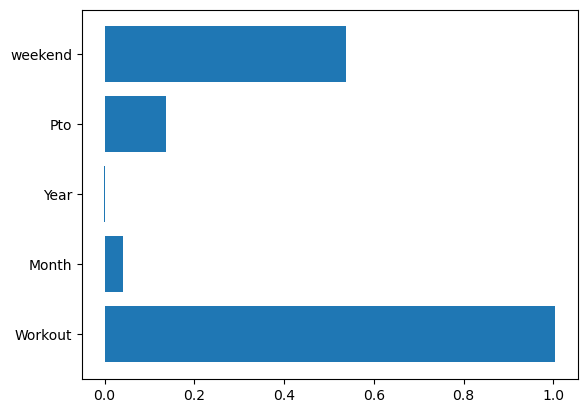

In [78]:
feat_importance2 = model2.coef_.flatten()
plt.barh(X2.columns, feat_importance2)

With a simplified version of the data (grouping weekday and weekends and removing workshift), the model is able to predict with slightly better accuracy at 69%. The overall message remains the same though. The husband has a higher chance of receiving healing hug on the weekends when his wife works out. 